In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('../data/HousingData.csv')

# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Handle missing values
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Separate features and target
X = data_imputed.drop('MEDV', axis=1)
y = data_imputed['MEDV']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Missing values per column:
CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


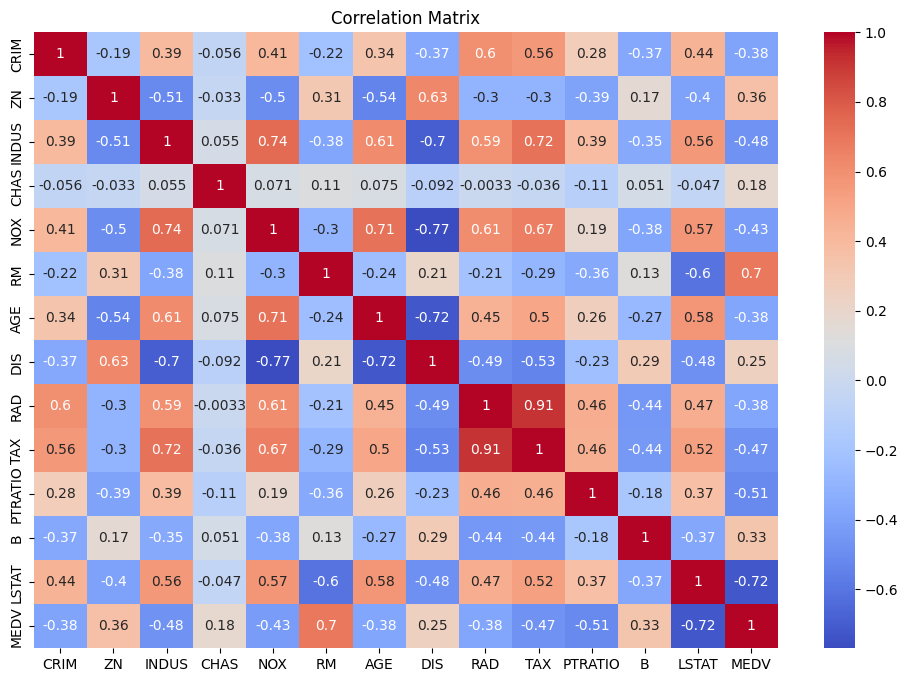

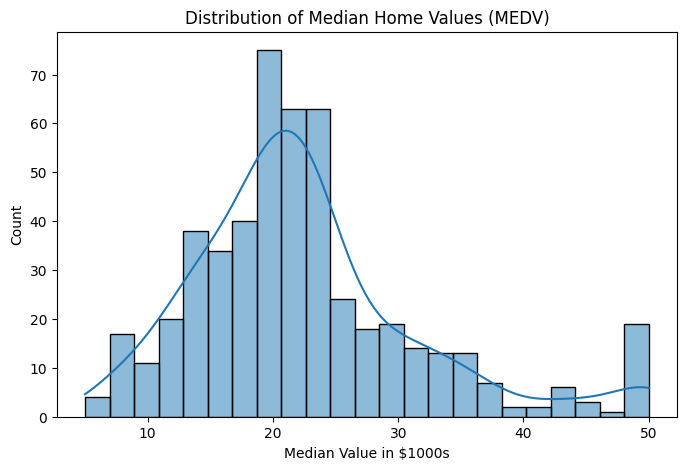

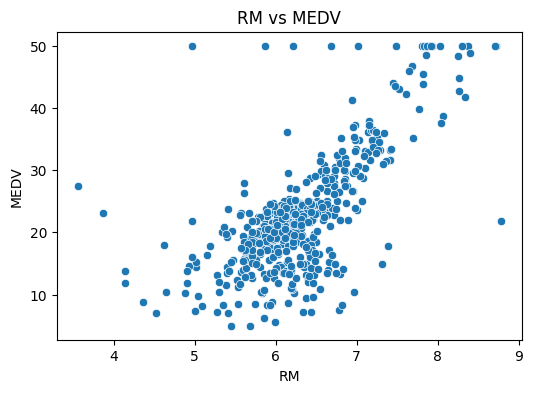

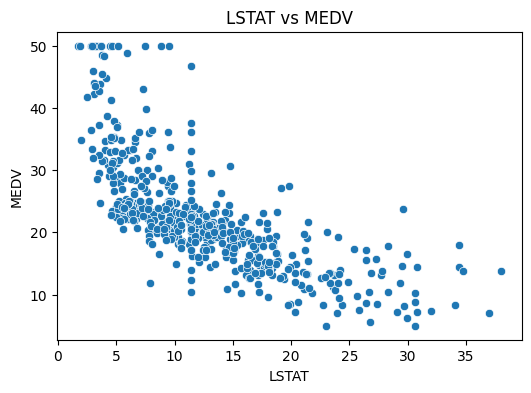

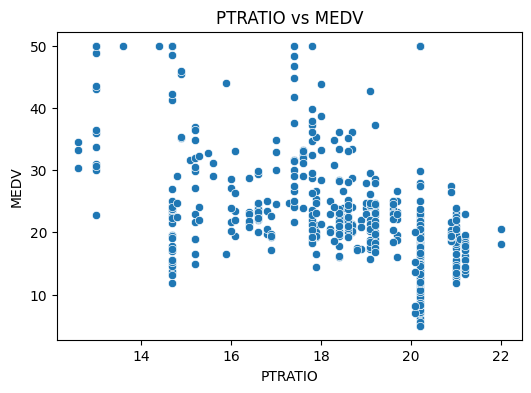

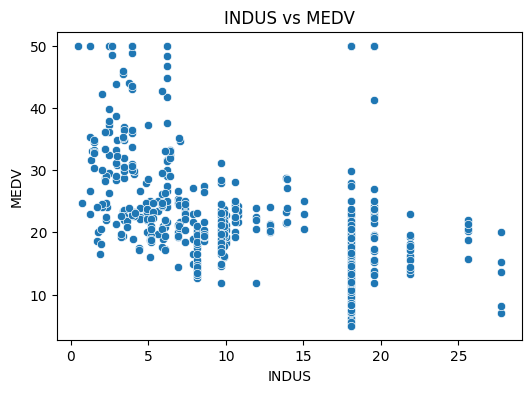

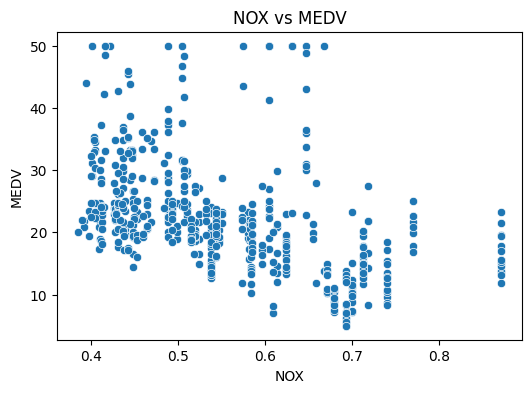

In [16]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = data_imputed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of target variable
plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True)
plt.title('Distribution of Median Home Values (MEDV)')
plt.xlabel('Median Value in $1000s')
plt.show()

# Relationship between important features and target
important_features = ['RM', 'LSTAT', 'PTRATIO', 'INDUS', 'NOX']
for feature in important_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=data_imputed[feature], y=y)
    plt.title(f'{feature} vs MEDV')
    plt.show()

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf')
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'CV R2 Mean': np.mean(cv_scores),
        'CV R2 Std': np.std(cv_scores)
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df.sort_values('R2', ascending=False))

                               RMSE        R2  CV R2 Mean  CV R2 Std
Gradient Boosting          2.705711  0.900171    0.828448   0.069172
Random Forest              2.872324  0.887497    0.806905   0.044862
Linear Regression          4.999938  0.659101    0.713596   0.060138
Ridge Regression           5.000272  0.659056    0.713771   0.060084
Lasso Regression           5.109139  0.644048    0.707786   0.061262
Support Vector Regression  5.144200  0.639146    0.618379   0.036135


In [20]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize grid search
gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
best_params = grid_search.best_params_
print("Best parameters:", best_params)
best_model = grid_search.best_estimator_

# Evaluate best model
y_pred = best_model.predict(X_test_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)
print(f"Final RMSE: {final_rmse:.2f}")
print(f"Final R2 Score: {final_r2:.2f}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Final RMSE: 2.62
Final R2 Score: 0.91


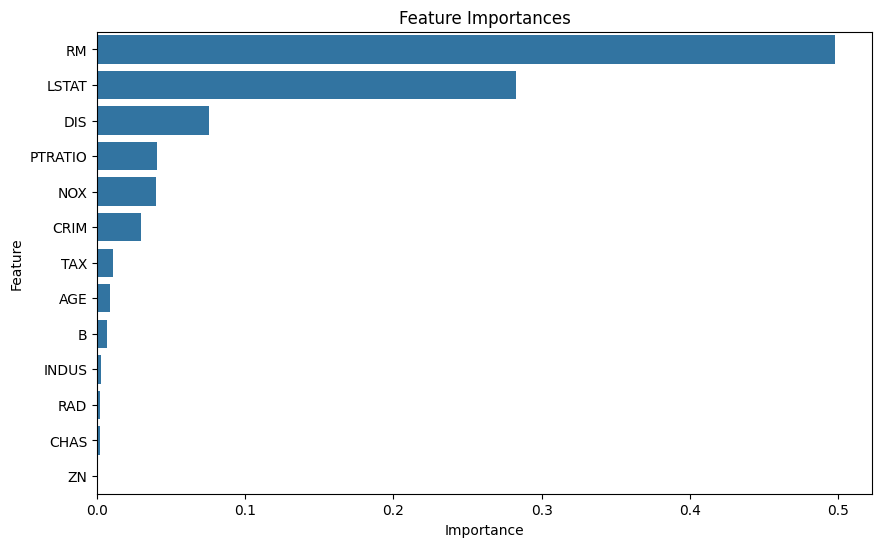

In [21]:
# Get feature importances
feature_importances = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

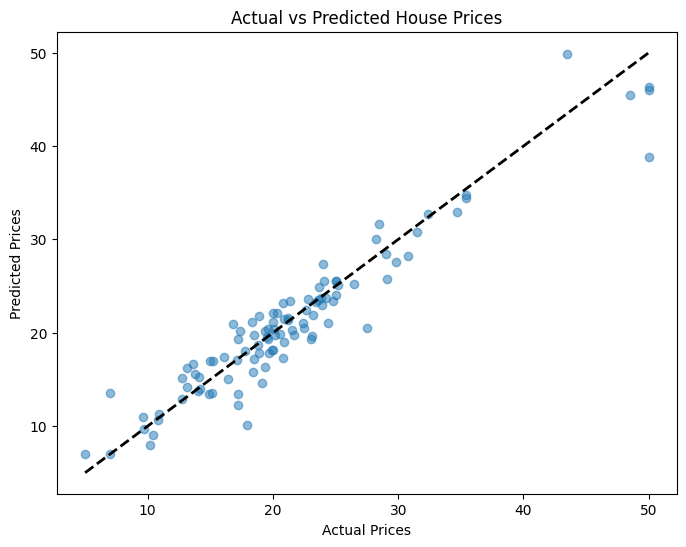

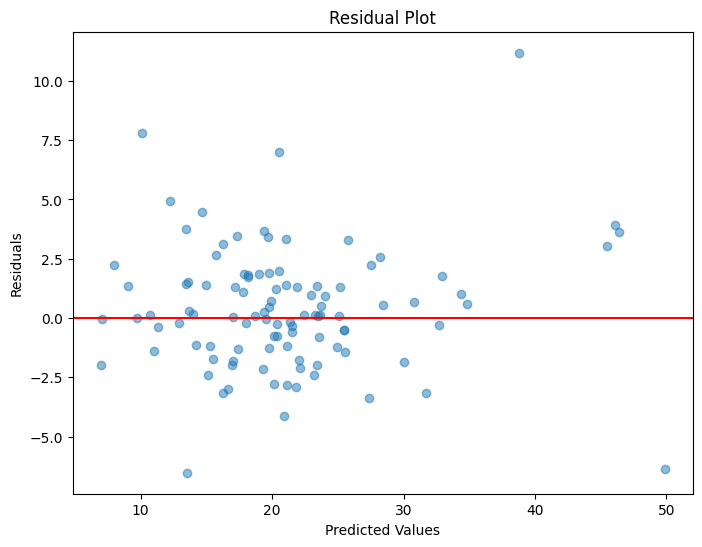

In [22]:
# Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [23]:
import joblib

# Save the model and scaler
joblib.dump(best_model, 'boston_housing_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# To load them later:
# model = joblib.load('boston_housing_model.pkl')
# scaler = joblib.load('scaler.pkl')

['scaler.pkl']

In [24]:
def predict_house_price(input_features):
    """
    Predicts Boston house price based on input features.
    
    Parameters:
    input_features (dict): Dictionary containing feature values
    
    Returns:
    float: Predicted house price in $1000s
    """
    # Create DataFrame from input features
    input_df = pd.DataFrame([input_features])
    
    # Load the scaler and model
    scaler = joblib.load('scaler.pkl')
    model = joblib.load('boston_housing_model.pkl')
    
    # Scale the input features
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction = model.predict(input_scaled)
    
    return prediction[0]

# Example usage:
example_features = {
    'CRIM': 0.02731,
    'ZN': 0.0,
    'INDUS': 7.07,
    'CHAS': 0.0,
    'NOX': 0.469,
    'RM': 6.421,
    'AGE': 78.9,
    'DIS': 4.9671,
    'RAD': 2.0,
    'TAX': 242.0,
    'PTRATIO': 17.8,
    'B': 396.9,
    'LSTAT': 9.14
}

predicted_price = predict_house_price(example_features)
print(f"Predicted house price: ${predicted_price * 1000:.2f}")

Predicted house price: $22043.35
